# Injecting and Measuring Artificial Stars in Single-Visit Images

Jeff Carlin <br>
Last verified to run Monday, April 26, 2022, with weekly 2022_12.

Recommended container size: large (or possibly medium; small will definitely run out of memory and kill the kernel).

This tutorial demonstrates a method to inject artificial stars into `calexp` images using the measured point-spread function of the given `calexp` image. It then shows how to run the pipelines' detection and measurement tasks on these images, extract the measurements of the artificial stars, and compare their measured magnitudes to the input (simulated) magnitudes.

#### Prerequisites

This tutorial assumes familiarity with afwDisplay, the Butler, and source detection with the LSST Science Pipelines.
Relevant tutorials can be found in the <a href="https://github.com/rubin-dp0/tutorial-notebooks">rubin-dp0/tutorial-notebooks</a> repository.
(For image display, see NBs 03a, 03b, and 08a; for the Butler, see NB 04; and for source detection, see NB 05).

## Introduction

This tutorial shows a way to use existing tools in the LSST Science Pipelines to inject artificial stars into processed single-visit images ("calexps"), then run the detection and measurement tasks to test the recovery of these stars and their (known) properties. In this particular notebook, the focus is on inserting _stars_ into the images because that is the simplest operation (requiring only a position and a flux/magnitude). However, the tools do exist to insert simulated galaxies (based on parameters describing their light distribution), or to insert images (for example, an image of a simulated galaxy cluster) into processed data. See <a href="https://community.lsst.org/t/new-tasks-for-fake-source-insertion/3722">this post</a> on the Community forum for an introduction to the current fake source injection tasks.

**NOTE**: The task that is used in this notebook to create fake stars will soon be deprecated and removed from the Science Pipelines, and its replacement tasks (discussed in the Community forum post linked above) will also soon be replaced with refactored and improved tasks. Once the new synthetic source code has arrived, this notebook should be updated to use the newer tasks.

<br>


The workflow in this notebook is as follows:

1. Starting with an RA, Dec position, find all single-visit images that overlap that position.
    - (For this tutorial, we select only a single visit image from each band.)
2. Given positions and input magnitudes for fake stars (in _ugri_ bands), figure out what the X, Y positions and fluxes should be in each image.
3. Inject those stars into the appropriate images with the X, Y positions and fluxes as calculated in the previous step, using the measured PSF for each individual image to create stellar images.
4. Run all processing steps (characterization, calibration, detection, deblending, measurement) on each image that fake stars were inserted into.
5. Compare the measured positions and fluxes/mags to the input synthetic values.

## Set Up

#### Import packages.

In [1]:
# Import python packages
import time
import os
import warnings
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import IFrame, display, Markdown
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
from astropy.visualization import ZScaleInterval
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

%matplotlib inline

In [2]:
# Import tasks from the LSST Science Pipelines for reprocessing images
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.calibrate import CalibrateTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask

In [3]:
# Import LSST Science Pipelines packages (see pipelines.lsst.io)
import lsst.daf.base as dafBase
from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom
import lsst.pipe.tasks.fakes as fakes

# Use lsst.afw.display with the matplotlib backend
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [9, 9],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

#### Instantiate the Butler.

In [5]:
# For DC2 gen3, these are the only optoins
repo = 's3://butler-us-central1-dp01'
collection = '2.2i/runs/DP0.1'

butler = Butler(repo, collections=collection)
registry = butler.registry

#### Create a list of artificial stars to inject: 

To inject artificial stars, all that is needed is a list of RA, Dec positions, and magnitudes to assign the simulated stars.

We will generate `nfakes` stars with positions randomly distributed (using a normal distribution of size `scatter_arcmin` in arcminutes) about the center coordinate (racen, deccen). The stars will be evenly spaced in u-band magnitude (i.e., in `nfakes` equal intervals between magmin and magmax), and randomly distributed about a mean color for each band. (I chose to use a fixed mean color for all stars for simplicity, but apply a normally-distributed scatter of `mag_scatter` magnitudes about this mean value so they are not all identical.)


In [6]:
# Central (RA, Dec) position (in degrees) at which to insert stars:
racen = 70.3
deccen = -37.15

# Place all the fake stars within `scatter_arcmin` arcminutes of the center coordinate:
scatter_arcmin = 1.0

# "nfakes" is the number of fake stars to inject:
nfakes = 31


np.random.seed(715)   # make it reproducable, not random

# Assign positions using a (random) normal distribution about the center coordinates:
fake_ras = racen + (np.random.randn(nfakes) * scatter_arcmin / 60.0)
fake_decs = deccen + (np.random.randn(nfakes) * scatter_arcmin / 60.0)

# Make artificial u magnitudes in a range:
min_umag = 16.0
max_umag = 20.0
mag_scatter = 0.3
fake_umags = np.linspace(min_umag, max_umag, nfakes)

# Now assign magnitudes in other bands using (~fixed) colors:
fake_gmags = fake_umags - (1.0 + mag_scatter * np.random.randn(nfakes))  # distrib centered on u-g=1.0
fake_rmags = fake_gmags - (0.4 + mag_scatter * np.random.randn(nfakes))  # distrib centered on g-r=0.4
fake_imags = fake_rmags - (0.2 + mag_scatter * np.random.randn(nfakes))  # distrib centered on r-i=0.2

# These are totally arbitrary colors, but should be kinda similar to BHB stars?

In [7]:
# print(fake_ras, fake_decs, fake_gmags)

### Look up the images that overlap the desired coordinates

We will use the spatial query method introduced in [notebook 04: Intro to the Butler](https://github.com/rubin-dp0/tutorial-notebooks/blob/main/04_Intro_to_Butler.ipynb).

In [8]:
import lsst.sphgeom

pixelization = lsst.sphgeom.HtmPixelization(12)

In [9]:
htm_id = pixelization.index(
    lsst.sphgeom.UnitVector3d(
        lsst.sphgeom.LonLat.fromDegrees(racen, deccen)
    )
)

# Obtain and print the scale to provide a sense of the size of the sky pixelization being used
scale = pixelization.triangle(htm_id).getBoundingCircle().getOpeningAngle().asDegrees()*3600
print(f'HTM ID={htm_id} at level={pixelization.getLevel()} is a ~{scale:0.2}" triangle.')

HTM ID=147743564 at level=12 is a ~6.8e+01" triangle.


#### Now query the registry for all "calexp" images overlapping the desired position:

In [10]:
datasetRefs = registry.queryDatasets("calexp", htm20=htm_id)

print("Found ", datasetRefs.count(), " calexps at that position.")

Found  555  calexps at that position.


That's nice, but it finds images from all bands overlapping the position in a single iterator. Let's get lists separately for each band:

In [11]:
datasetRefs_u = registry.queryDatasets("calexp", htm20=htm_id, band="u")
datasetRefs_g = registry.queryDatasets("calexp", htm20=htm_id, band="g")
datasetRefs_r = registry.queryDatasets("calexp", htm20=htm_id, band="r")
datasetRefs_i = registry.queryDatasets("calexp", htm20=htm_id, band="i")

print("Found ", datasetRefs_u.count(), " u-band calexps at that position.")
print("Found ", datasetRefs_g.count(), " g-band calexps at that position.")
print("Found ", datasetRefs_r.count(), " r-band calexps at that position.")
print("Found ", datasetRefs_i.count(), " i-band calexps at that position.")

Found  33  u-band calexps at that position.
Found  63  g-band calexps at that position.
Found  141  r-band calexps at that position.
Found  138  i-band calexps at that position.


For now, let's just grab the first image in the list for each band.

In [12]:
for i, ref in enumerate(datasetRefs_u):
    uref = ref
    if i > 0:
        break

for i, ref in enumerate(datasetRefs_g):
    gref = ref
    if i > 0:
        break

for i, ref in enumerate(datasetRefs_r):
    rref = ref
    if i > 0:
        break

for i, ref in enumerate(datasetRefs_i):
    iref = ref
    if i > 0:
        break


What does that `datasetRef` object look like?

In [13]:
iref

DatasetRef(DatasetType('calexp', {band, instrument, detector, physical_filter, visit_system, visit}, ExposureF), {instrument: 'LSSTCam-imSim', detector: 5, visit: 924041, ...}, id=3a557ef0-1f3b-41ff-9aa7-5ef1fea20fac, run='2.2i/runs/DP0.1/calexp/v1')

### Make stars and inject them into images:

First, write a function ("makeFakeStar") that takes as inputs the position, flux (intensity), and the PSF, and returns an image of the PSF scaled to the desired flux at the input position.

Next, we add a function ("addFakeStars") that takes the list of RAs, Decs, and magnitudes, and a `datasetRef` for a `calexp` image, and returns a version of the input `calexp` that has the fake stars injected into it. (This function calls "makeFakeStar" for each star in the list.)

The source injection steps were developed following this piece of code as an example: https://github.com/lsst/pipe_tasks/blob/387f8f07a2b66205f9fa6bda9a89dcdbbef3f64c/tests/test_fakeProcessing.py

In [14]:
# make stars at a given position with a given intensity
def makeFakeStar(position, intensity, psf):
    psfImage = psf.computeImage(geom.Point2D(position.x, position.y)).getArray()
    psfImage *= intensity
    noise = np.random.normal(0, np.sqrt(abs(psfImage)))
    return psfImage + noise, noise

In [15]:
def addFakeStars(ras, decs, mags, calexp_ref):
    calexp_inp = butler.get('calexp', calexp_ref.dataId)
    calexp_withFakes = calexp_inp.clone()

    # Fetch objects from the exposure
    psf = calexp_withFakes.getPsf()
    image = calexp_withFakes.getMaskedImage().getImage()
    variance = calexp_withFakes.getMaskedImage().getVariance()
    wcs = calexp_withFakes.getWcs()
    photocalib = calexp_withFakes.getPhotoCalib()

    fluxes = []
    
    noise_scale = np.mean(image.getArray())    
    image_size = image.getArray().shape
    
    print('noise_scale = ',noise_scale)
    print('image_size = ',image_size)
    
    
    '''
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    plt.sca(ax[0])  # set the first axis as current
    display1 = afwDisplay.Display(frame=fig)
    display1.scale('linear', 'zscale')
    display1.mtv(image)
    plt.title('original image')
    #plt.xlim(1000, 2500)
    #plt.ylim(300, 1800)
    plt.sca(ax[1])  # set the second axis as current
    display2 = afwDisplay.Display(frame=fig)
    display2.scale('linear', 'zscale')
    display2.mtv(image)
    # display2.mtv(image0)
    plt.title('with fake stars')
    #plt.xlim(1000, 2500)
    #plt.ylim(300, 1800)
    plt.tight_layout()
    plt.show()
    '''
    
    #image.getArray()[:,:] = np.random.normal(loc=noise_scale,scale=noise_scale,) # = image.getArray()*0.

    # Use the "photocalib" from the calexp to convert magnitudes to instrumental fluxes:
    for mag in mags:
        fluxes.append(photocalib.magnitudeToInstFlux(mag))

    # Get the corner coordinates of the image:
    y0 = image.getY0()
    x0 = image.getX0()
    ymax = y0 + calexp_withFakes.getDimensions()[1]
    xmax = x0 + calexp_withFakes.getDimensions()[0]

    #xvals = []
    #yvals = []
    
    # At each position create a star with the given intensity and add it
    # to the image.
    for ra, dec, intensity in zip(ras, decs, fluxes):
        # Use the WCS to convert RA, Dec to X, Y pixel coordinates:
        pos = wcs.skyToPixel(geom.SpherePoint(ra, dec, geom.degrees))
        #xvals.append(pos.x)
        #yvals.append(pos.y)

        # Call "makeFakeStar" to get the image of a PSF-like object with the desired flux:
        objArray, noiseArray = makeFakeStar(pos, intensity, psf)
        psfRad = int((objArray.shape[0]-1)/2.)

        # Check that the desired position is within the image:
        oky = (pos.y > psfRad) & (pos.y < ymax - psfRad)
        okx = (pos.x > psfRad) & (pos.x < xmax - psfRad)

        if okx & oky:
            yslice = slice(int(np.floor(pos.y - psfRad - y0)), int(np.floor(pos.y + psfRad + y0 + 1)))
            xslice = slice(int(np.floor(pos.x - psfRad - x0)), int(np.floor(pos.x + psfRad + x0 + 1)))

            print('Injecting source at x, y = ', pos.x, pos.y)

            # NOTE: while image arrays are indexed with x, y, the extraction of the data into (numpy) arrays
            # means that the returned arrays follow numpy's y, x convention.
            # More on indexing: https://pipelines.lsst.io/modules/lsst.afw.image/indexing-conventions.html
            image.getArray()[yslice, xslice] += objArray
            variance.getArray()[yslice, xslice] += noiseArray**2
        else:
            print('Skipped injecting source at x, y = ', pos.x, pos.y, ' because it is too close to (or off) the edge.')

    return calexp_inp, calexp_withFakes

### Call the "addFakeStars" function to create calexp images with the artificial stars injected:

In [16]:
calexp_orig_u, calexp_new_u = addFakeStars(fake_ras, fake_decs, fake_umags, uref)
calexp_orig_g, calexp_new_g = addFakeStars(fake_ras, fake_decs, fake_gmags, gref)
calexp_orig_r, calexp_new_r = addFakeStars(fake_ras, fake_decs, fake_rmags, rref)
calexp_orig_i, calexp_new_i = addFakeStars(fake_ras, fake_decs, fake_imags, iref)

noise_scale =  1.2538352
image_size =  (4000, 4072)
Injecting source at x, y =  424.9047875652484 1220.69069003251
Injecting source at x, y =  842.4727579551229 1218.8302708621702
Injecting source at x, y =  1187.7596234205605 1490.611799698317
Injecting source at x, y =  632.241738249608 1535.0727284774189
Injecting source at x, y =  989.2169948012784 1861.6260840838715
Injecting source at x, y =  688.9503648836608 1646.172251383764
Injecting source at x, y =  1113.5152018640706 1187.297825459618
Injecting source at x, y =  876.3488839395916 1592.0629977063113
Injecting source at x, y =  810.125381328123 1580.568077570345
Injecting source at x, y =  819.4240634574858 1576.7227058810356
Injecting source at x, y =  735.7415162820707 1080.7352135002056
Injecting source at x, y =  610.2330778619169 1221.3223939650902
Injecting source at x, y =  677.7691116461892 1540.5879265013727
Injecting source at x, y =  727.0143675981601 1511.6628143362113
Injecting source at x, y =  220.685357341144

### Wrap all of the detection and measurement steps in a function.

The steps here follow the <a href="https://github.com/rubin-dp0/tutorial-notebooks/blob/main/05_Intro_to_Source_Detection.ipynb">Intro to Source Detection</a> tutorial notebook, so rather than explain them in detail here, we simply wrap all the steps in a single function that can be executed for each image.

In [17]:
def processFakes(calexp_inp, calexp_inp_new):
    
    # Create a basic schema to use with these tasks
    schema = afwTable.SourceTable.makeMinimalSchema()

    print('schema = ')
    print(schema)
    
    # Create a container which will be used to record metadata about algorithm execution
    algMetadata = dafBase.PropertyList()

    # Initialize CharacterizeImageTask and its configuration:
    config = CharacterizeImageTask.ConfigClass()
    config.psfIterations = 1
    charImageTask = CharacterizeImageTask(None, config=config)

    # Initialize SourceDetectionTask and its configuration:
    config = SourceDetectionTask.ConfigClass()
    config.thresholdValue = 10      # detection threshold in units of thresholdType
    config.thresholdType = "stdev"   # units for thresholdValue
    sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)
    sourceDeblendTask = SourceDeblendTask(schema=schema)

    # Initialize SingleFrameMeasurementTask and its configuration:
    config = SingleFrameMeasurementTask.ConfigClass()
    sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config, algMetadata=algMetadata)

    #print('after config, schema = ')
    #print(schema)

    
    # Make an empty table that we'll put the results in:
    tab = afwTable.SourceTable.make(schema)
    
    # Image characterization
#    I'm not sure what this does or if it is necessary, but it seems to take a long time - Brian Morsony, 7/29/2022
#    result = charImageTask.run(calexp_inp)

    # Get the PSF and some image properties
#    psf = calexp_inp.getPsf()
#    sigma = psf.computeShape().getDeterminantRadius()
    pixelScale = calexp_inp.getWcs().getPixelScale().asArcseconds()

    # The factor of 2.355 converts from std to fwhm
    
    sigma = 1./pixelScale/2.355
    print('psf fwhm = {:.2f} arcsec'.format(sigma*pixelScale*2.355))
    
    
    # Run source detection
    result = sourceDetectionTask.run(tab, calexp_inp_new)
    
    
    sources = result.sources

    del result

    sources = sources.copy(True)
    
    
    # Run source deblending
    sourceDeblendTask.run(calexp_inp, sources)

    
    # Run source measurement
    sourceMeasurementTask.run(measCat=sources, exposure=calexp_inp)

    
    
    # The copy makes sure that the sources are sequential in memory
    sources = sources.copy(True)
    
    # For convenience, return an Astropy table:
    source_tab = sources.asAstropy()
    
    # Convert fluxes to magnitudes and add them to the table
    photocalib = calexp_inp.getPhotoCalib()
    psfmags = photocalib.instFluxToMagnitude(sources, 'base_PsfFlux')
    source_tab.add_columns([psfmags[:,0], psfmags[:,1]], names=['mag_psf', 'magerr_psf'])
    
    return(source_tab)

### Run the "processFakes" function on each image that we injected fake stars into

**This may take at least a couple minutes to run**

In [18]:
t1 = time.time()

sources_withfakes_u = processFakes(calexp_orig_u,calexp_new_u)
sources_withfakes_g = processFakes(calexp_orig_g,calexp_new_g)
sources_withfakes_r = processFakes(calexp_orig_r,calexp_new_r)
sources_withfakes_i = processFakes(calexp_orig_i,calexp_new_i)

t2 = time.time()
print('dt', t2 - t1)

schema = 
Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)

psf fwhm = 1.00 arcsec


schema = 
Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)

psf fwhm = 1.00 arcsec


schema = 
Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)

psf fwhm = 1.00 arcsec


schema = 
Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)

psf fwhm = 1.00 arcsec


dt 41.350167751312256


In [19]:
# Take a look at the catalog:

sources_withfakes_u



id,coord_ra,coord_dec,parent,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,deblend_peak_center_x,deblend_peak_center_y,deblend_peakId,deblend_nPeaks,deblend_parentNPeaks,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_LocalBackground_flag_badCentroid_badError,base_NaiveCentroid_flag_badInitialCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,base_Variance_flag_badCentroid_badError,slot_Centroid_flag_badError,base_Blendedness_old,base_Blendedness_raw,base_Blendedness_raw_child_instFlux,base_Blendedness_raw_parent_instFlux,base_Blendedness_abs,base_Blendedness_abs_child_instFlux,base_Blendedness_abs_parent_instFlux,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_parent_yy,base_Blendedness_raw_parent_xy,base_Blendedness_abs_child_xx,base_Blendedness_abs_child_yy,base_Blendedness_abs_child_xy,base_Blendedness_abs_parent_x

### Match coordinates from the original list of fake stars to the new catalog:

In [20]:
# Coordinates of input fake stars
sc_fakes = SkyCoord(ra=fake_ras*u.deg, dec=fake_decs*u.deg, frame='icrs')

# Coordinates of objects in calexps with fakes added:
sc_withfakes_u = SkyCoord(ra=sources_withfakes_u['coord_ra'], dec=sources_withfakes_u['coord_dec'], frame='icrs')
sc_withfakes_g = SkyCoord(ra=sources_withfakes_g['coord_ra'], dec=sources_withfakes_g['coord_dec'], frame='icrs')
sc_withfakes_r = SkyCoord(ra=sources_withfakes_r['coord_ra'], dec=sources_withfakes_r['coord_dec'], frame='icrs')
sc_withfakes_i = SkyCoord(ra=sources_withfakes_i['coord_ra'], dec=sources_withfakes_i['coord_dec'], frame='icrs')
# Note that units weren't required for sc_withfakes_*, because it already has them.

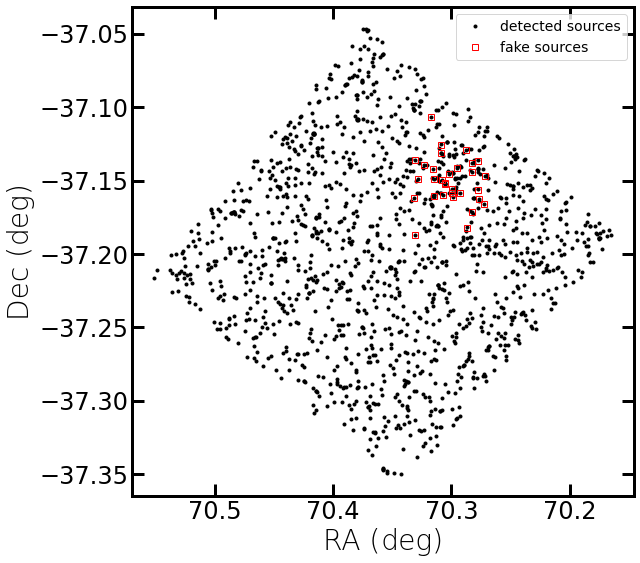

In [21]:
fig, ax = plt.subplots(1, 1)
plt.plot(sc_withfakes_g.ra, sc_withfakes_g.dec, '.k', label='detected sources')
plt.plot(sc_fakes.ra, sc_fakes.dec, 'sr', fillstyle='none', label='fake sources')
ax.invert_xaxis()
plt.legend()
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.show()

In [22]:
# Match them using the Astropy SkyCoord "match_to_catalog_sky" method:

idx_u, sep_u, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_u)
idx_g, sep_g, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_g)
idx_r, sep_r, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_r)
idx_i, sep_i, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_i)

The "idx*" arrays are the indices into sc_withfakes* files to extract the closest match, and "sep*" are the actual separations between the sources. Note that this returns a separation for all objects -- in the following, we will keep only sources with match separations less than 1 arcsecond (i.e., "good" matches).

Extract info about the good matches into arrays:

In [23]:
okmch_u = (sep_u.arcsec < 1.0)
mch_mags_u = sources_withfakes_u[idx_u]['mag_psf']
mch_magerrs_u = sources_withfakes_u[idx_u]['magerr_psf']
# If the nearest match is >1" away, set its magnitudes to -99.9:
mch_mags_u[~okmch_u] = -99.9
mch_magerrs_u[~okmch_u] = 99.9
seps_u = sep_u.arcsec

okmch_g = (sep_g.arcsec < 1.0)
mch_mags_g = sources_withfakes_g[idx_g]['mag_psf']
mch_magerrs_g = sources_withfakes_g[idx_g]['magerr_psf']
mch_mags_g[~okmch_g] = -99.9
mch_magerrs_g[~okmch_g] = 99.9
seps_g = sep_g.arcsec

okmch_r = (sep_r.arcsec < 1.0)
mch_mags_r = sources_withfakes_r[idx_r]['mag_psf']
mch_magerrs_r = sources_withfakes_r[idx_r]['magerr_psf']
mch_mags_r[~okmch_r] = -99.9
mch_magerrs_r[~okmch_r] = 99.9
seps_r = sep_r.arcsec

okmch_i = (sep_i.arcsec < 1.0)
mch_mags_i = sources_withfakes_i[idx_i]['mag_psf']
mch_magerrs_i = sources_withfakes_i[idx_i]['magerr_psf']
mch_mags_i[~okmch_i] = -99.9
mch_magerrs_i[~okmch_i] = 99.9
seps_i = sep_i.arcsec

#print(fake_imags[okmch], sources_withfakes_i[idx_i[okmch]]['mag_psf'])

In [24]:
# sep_g.arcsec

Combine all of the information into a single table:

In [25]:
tab_all = Table([fake_ras, fake_decs, fake_umags, fake_gmags, fake_rmags, fake_imags,
                 mch_mags_u, mch_magerrs_u, seps_u, mch_mags_g, mch_magerrs_g, seps_g,
                 mch_mags_r, mch_magerrs_r, seps_r, mch_mags_i, mch_magerrs_i, seps_i],
                 names=['ra', 'dec', 'u_fake', 'g_fake', 'r_fake', 'i_fake', 'u_meas', 'uerr_meas', 'sep_u',
                        'g_meas', 'gerr_meas', 'sep_g', 'r_meas', 'rerr_meas', 'sep_r',
                        'i_meas', 'ierr_meas', 'sep_i'],
                 units=[u.deg, u.deg, u.mag, u.mag, u.mag, u.mag, u.mag, u.mag, u.arcsec,
                        u.mag, u.mag, u.arcsec, u.mag, u.mag, u.arcsec, u.mag, u.mag, u.arcsec])

for col in tab_all.colnames[0:2]:
    tab_all[col].info.format = '%.8g'  # for consistent table output
for col in tab_all.colnames[2:]:
    tab_all[col].info.format = '%.5g'  # for consistent table output


In [26]:
tab_all

ra,dec,u_fake,g_fake,r_fake,i_fake,u_meas,uerr_meas,sep_u,g_meas,gerr_meas,sep_g,r_meas,rerr_meas,sep_r,i_meas,ierr_meas,sep_i
deg,deg,mag,mag,mag,mag,mag,mag,arcsec,mag,mag,arcsec,mag,mag,arcsec,mag,mag,arcsec
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
70.272902,-37.165753,16,14.966,14.275,13.8,nan,2.9332,0.22772,26.802,1.0728,0.11342,nan,6.8333,0.11961,nan,4.1386,0.11869
70.282863,-37.143961,16.133,14.969,14.819,14.835,-99.9,99.9,2.3101,26.16,0.59827,0.24805,nan,15.114,0.14649,nan,0.47936,0.15372
70.308958,-37.131174,16.267,15.108,14.49,14.673,nan,0.56332,0.19513,27.081,1.3832,0.2422,nan,4.409,0.19069,29.23,36.265,0.22923
70.298463,-37.160971,16.4,15.003,14.132,14.177,26.467,2.2489,0.050495,26.382,0.73026,0.046211,-99.9,99.9,1.0372,26.155,2.1361,0.13744
70.328426,-37.148619,16.533,15.668,15.011,14.707,nan,0.80131,0.1325,26.34,0.70501,0.10081,nan,1.8365,0.18797,nan,0.45603,0.13884
70.307096,-37.160143,16.667,15.623,15.333,14.917,28.267,11.767,0.37931,nan,1.4357,0.15731,42.088,4.1865e+06,0.17687,nan,0.83807,0.051896
70.287343,-37.129236,16.8,15.496,14.786,14.426,nan,0.81949,0.11905,27.756,2.5757,0.21982,nan,0.55239,0.18264,nan,1.3096,0.12808
70.308079,-37.149342,16.933,16.438,15.987,15.88,nan,3.2011,0.070905,nan,1.7736,0.13136,nan,0.59172,0.15108,nan,0.63346,0.084153


Now we have completed all the steps of injecting fake sources, running pipeline tasks to detect and measure all sources in the resulting images, and extracting the matches from the catalogs. Let's look at the results!

Compare the "fake" magnitudes we assigned to each star to their output (measured) magnitude:

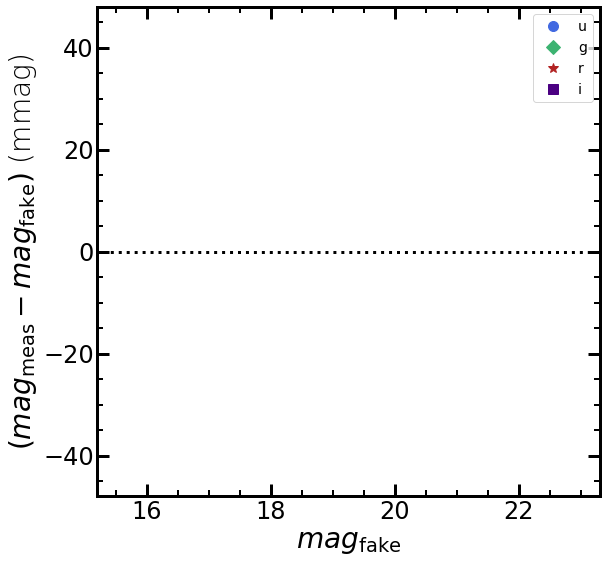

In [27]:
fig = plt.plot(figsize=(9, 9))

plt.hlines(0, 0, 30, linestyle=':', color='Black')
plt.plot(tab_all['u_fake'], 1000.0 * (tab_all['u_meas'] - tab_all['u_fake']),
         'o', ms=10, color='royalblue', label='u')
plt.plot(tab_all['g_fake'], 1000.0 * (tab_all['g_meas'] - tab_all['g_fake']),
         'D', ms=10, color='mediumseagreen', label='g')
plt.plot(tab_all['r_fake'], 1000.0 * (tab_all['r_meas'] - tab_all['r_fake']),
         '*', ms=10, color='firebrick', label='r')
plt.plot(tab_all['i_fake'], 1000.0 * (tab_all['i_meas'] - tab_all['i_fake']),
         's', ms=10, color='indigo', label='i')
plt.legend()
plt.xlabel(r'$mag_{\rm fake}$')
plt.ylabel(r'$(mag_{\rm meas} - mag_{\rm fake})$ (mmag)')
plt.xlim(15.2, 23.3)
plt.ylim(-48, 48)
plt.minorticks_on()
plt.show()

Looks good! (Note that the y-axis is showing residuals in _millimags_.)

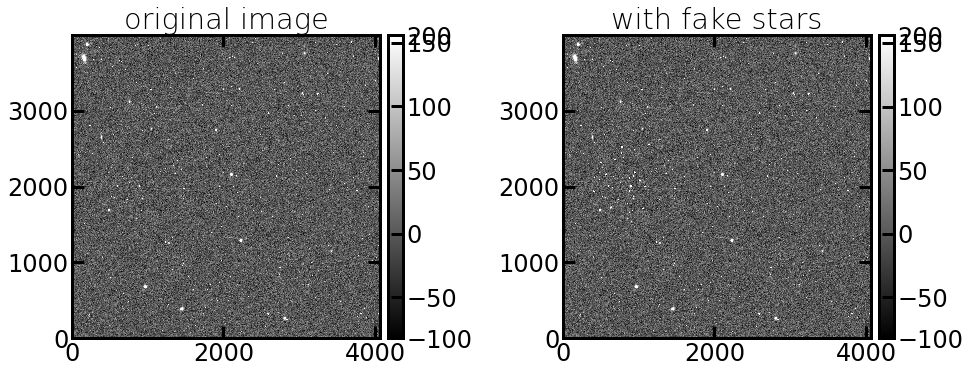

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
plt.sca(ax[0])  # set the first axis as current
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(calexp_orig_g.image)
plt.title('original image')
#plt.xlim(1000, 2500)
#plt.ylim(300, 1800)
plt.sca(ax[1])  # set the second axis as current
display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
display2.mtv(calexp_new_g.image)
# display2.mtv(image0)
plt.title('with fake stars')
#plt.xlim(1000, 2500)
#plt.ylim(300, 1800)
plt.tight_layout()
plt.show()

Ideas for further exploration:

- Inject stars using a realistic stellar population (i.e., get colors and a luminosity function from isochrones).
- Inject galaxies or other objects.
- Inject periodic variables into a set of overlapping visit images (using their time of observation to determine the input phase, and thus magnitude, for each image).
- Test completeness of detection/measurement (will need to inject stars over a variety of magnitudes and colors, and probably many times over to build up a large enough statistical sample).
